In [7]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
#from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

C:\Users\Asus\AppData\Local\Temp\ipykernel_26344\2175932427.py:30: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


# Load dataset
The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.

In [8]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [9]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


Each participant file contains two arrays: a "data" array (40 trials x 40 channels x 8064 data) and a "label" array (40 trials x 4 subjective ratings: valence, arousal, dominance, liking). We combine the data files into 2 new arrays with 880 trials for 22/32 participants (participants with frontal videos recorded).

In [15]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(880, 40, 8064)

In [16]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (880, 4)
Data:  (880, 40, 8064)


# Explore and pre-process data

## Labels

#### Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

In [17]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


In [18]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


<AxesSubplot:>

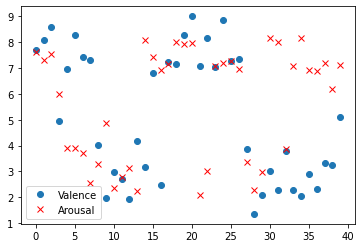

In [19]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

#### Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [20]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [21]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 457
Negative Valence: 423
High Arousal: 442
Low Arousal: 438


In [22]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 242
Low Arousal Positive Valence: 215
High Arousal Negative Valence: 200
Low Arousal Negative Valence: 223


In [23]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x27e82330640>,
 'caps': [<matplotlib.lines.Line2D at 0x27e82330be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x27e82330370>,
 'medians': [<matplotlib.lines.Line2D at 0x27e8233a1c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x27e8233a490>,
 'means': []}

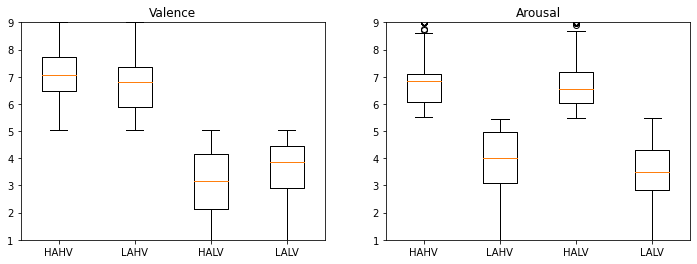

In [24]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x27e824f83d0>,
 'caps': [<matplotlib.lines.Line2D at 0x27e824f8970>,
 'boxes': [<matplotlib.lines.Line2D at 0x27e824f8100>,
 'medians': [<matplotlib.lines.Line2D at 0x27e824f8f10>,
 'fliers': [<matplotlib.lines.Line2D at 0x27e82503220>,
 'means': []}

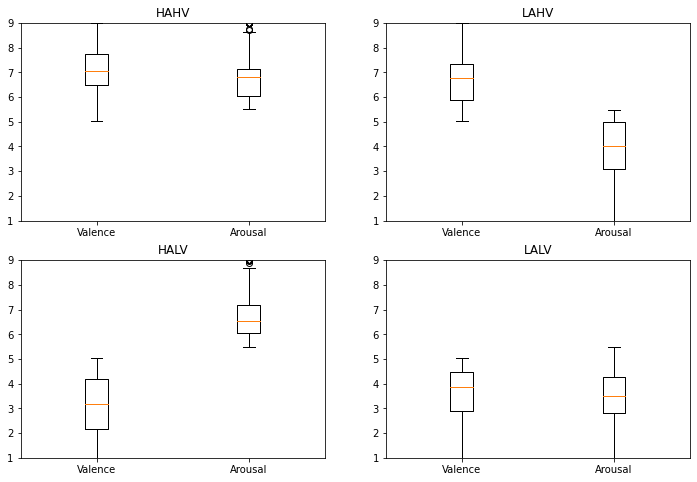

In [25]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

#### One hot encoding

In [26]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [27]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [28]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [29]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [30]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [31]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


### Welch's feature extraction

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral
power for each electrode. The frequency bands used:
theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz),
and gamma (30 - 64 Hz).

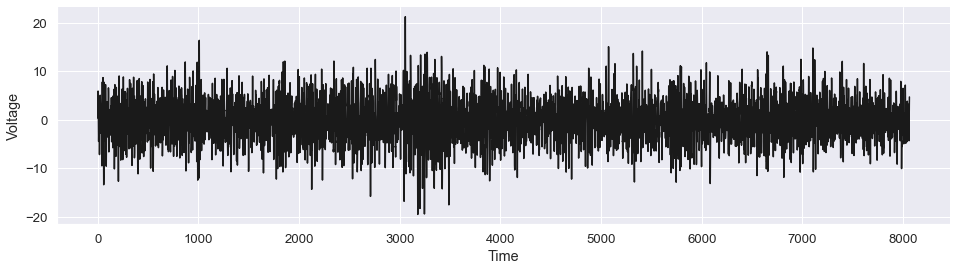

In [32]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

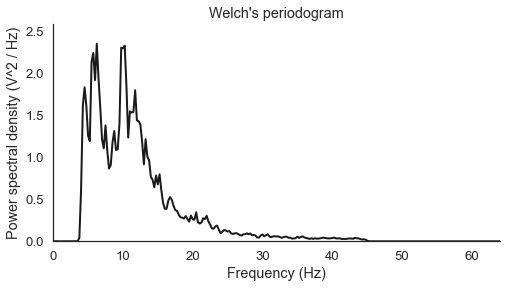

In [33]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

#### Theta band power

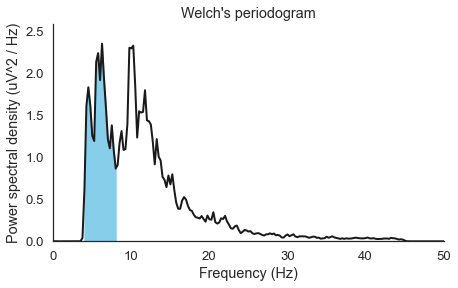

In [34]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Alpha band power

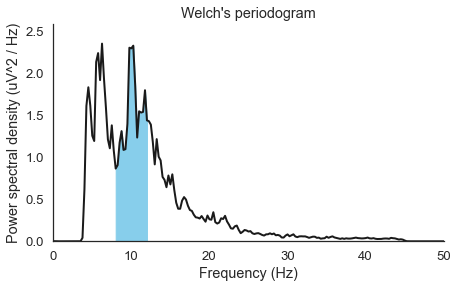

In [35]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Beta band power

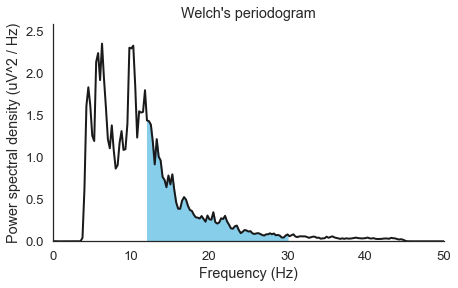

In [36]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Gamma band power

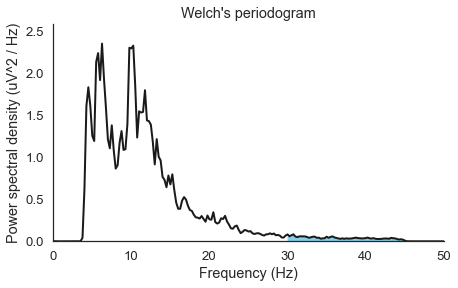

In [37]:
# Define delta lower and upper limits
low, high = 30, 64

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Functions to get band power values

In [38]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [39]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295194
6.286556266834863
0.9879159580139809


### Create EEG plots

#### General plots

In [40]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [41]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [42]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


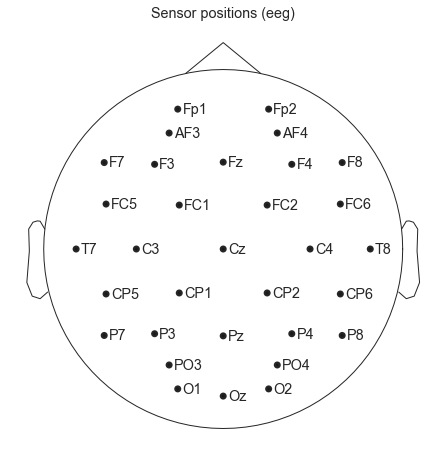

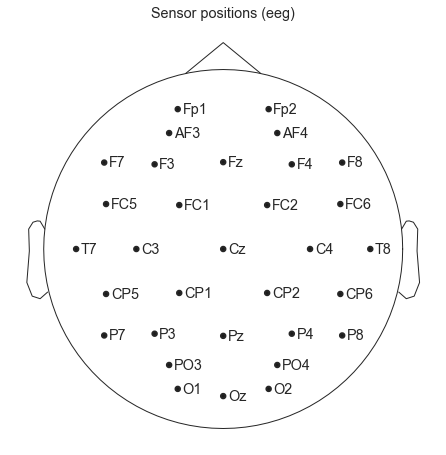

In [43]:
# Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

Effective window size : 16.000 (s)


C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\evoked.py:537: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax._span_selector = SpanSelector(


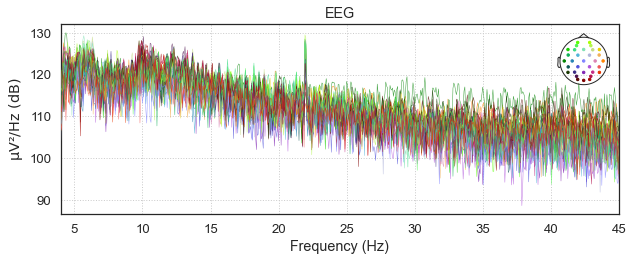

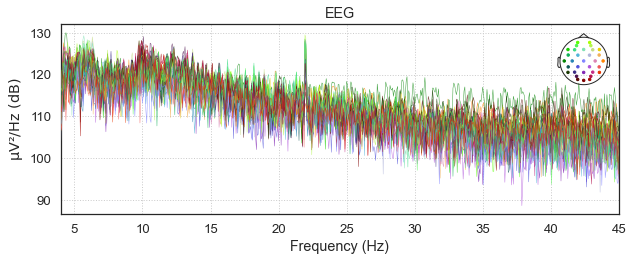

In [44]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

#### Topomaps for each band of frequencies

Following this thread: https://mail.nmr.mgh.harvard.edu/pipermail//mne_analysis/2019-April/005812.html

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\vi

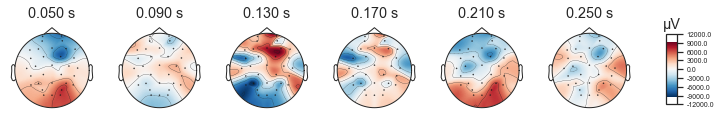

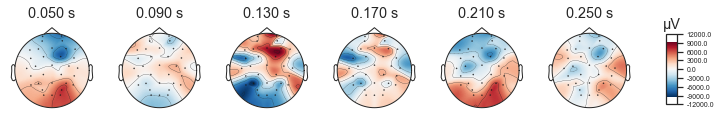

In [45]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\vi

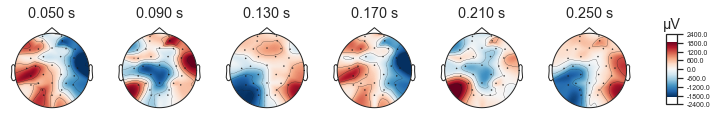

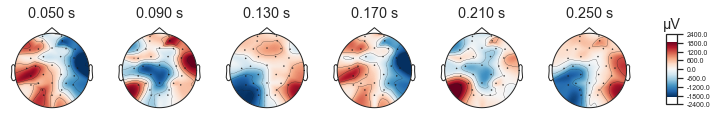

In [46]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\vi

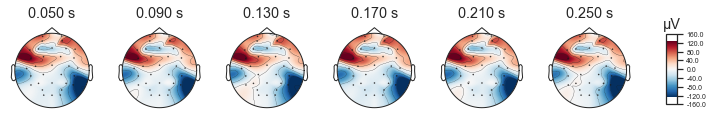

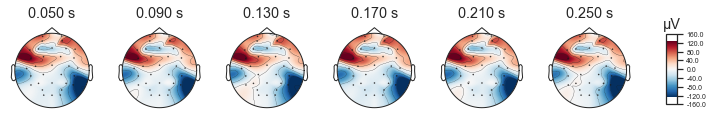

In [47]:
# Beta band, first trial
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\vi

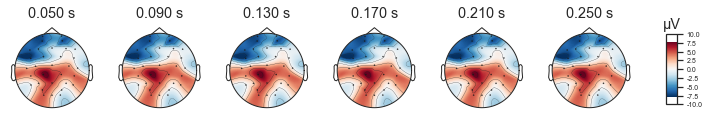

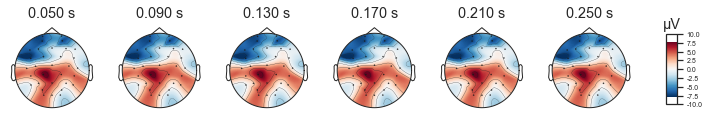

In [48]:
# Gamma band, first trial
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups

In [49]:
# Getting samples from 4 label groups, same subject
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [50]:
# Plot the topographies across different frequency bands
def plot_topo_psd(evData):
  evData.filter(4, 8) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(8, 12) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(12, 30) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(30, 63.9) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

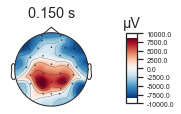

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

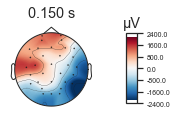

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

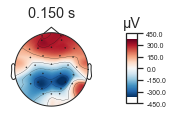

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

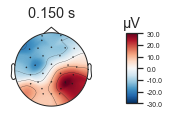

In [51]:
plot_topo_psd(ev_data_hahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

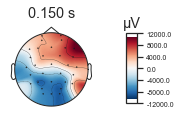

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

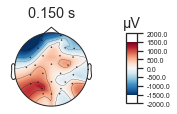

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

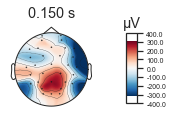

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

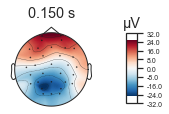

In [52]:
plot_topo_psd(ev_data_halv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

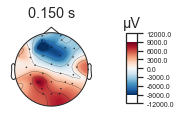

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

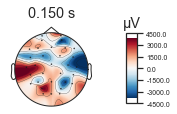

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

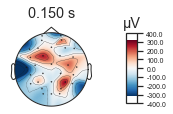

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

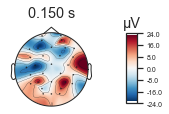

In [53]:
plot_topo_psd(ev_data_lahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

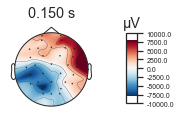

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

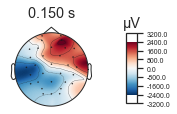

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

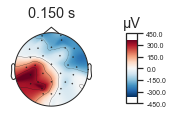

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1238: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidpress = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1240: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  self.cidrelease = self.cbar.patch.figure.canvas.mpl_connect(
C:\Users\Asus\anaconda3\lib\site-packages\mne\viz\utils.py:1242: MatplotlibDeprecationWarning: 
The patch attribute was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ax instead.
  sel

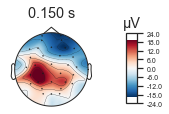

In [54]:
plot_topo_psd(ev_data_lalv)

### Process new datasets with 6 EEG regions and 4 band power values

In [55]:
# Transform 880 x 32 x 8064 => 880 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (880, 128))

EEG channels are divided into 6 groups, according to their cerebral spatial locations. We combine the temmporal-left and temporal-right channels into the left and right groups. The frontal group only includes the fronto-central channels. All centro-parietal channels are included in the central group.

In [56]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

#### Dataframe for Theta power values

In [57]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (880, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.476747e+02  1.275351e+03  9.614382e+02  2.081203e+03  9.465240e+02   
std    1.217600e+03  3.736193e+03  3.558854e+03  5.918715e+03  2.572982e+03   
min    2.895855e-12  5.217485e-12  8.531922e-12  1.108519e-11  4.114167e-12   
25%    2.409321e+01  1.860138e+01  2.204631e+01  3.912328e+01  1.387218e+01   
50%    5.845061e+01  7.275575e+01  7.399130e+01  1.053462e+02  4.300044e+01   
75%    3.662748e+02  3.134779e+02  1.963466e+02  2.787570e+02  2.560120e+02   
max    1.552414e+04  3.812287e+04  3.943132e+04  4.927279e+04  2.018267e+04   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   3.356400e+02  6.296681e+02  3.841360e+02  4.374546e+02  2.786658e+02   
std    7.140925e+02  1.774593e+03  6.900685e+02  1.

In [58]:
# Only print central channels
print(df_theta[central].head(5)) 

            CP5           CP1            Cz            C4            C3  \
0  2.881030e-12  1.102969e-11  7.516943e-12  2.045050e-12  4.197735e-12   
1  3.869735e-11  3.822071e-11  3.480808e-12  3.943074e-12  5.063776e-11   
2  3.711943e+00  1.890259e+00  2.386166e+00  3.942938e+00  4.284358e+00   
3  4.004765e+00  1.883543e+00  7.414694e+00  3.498076e+00  4.171965e+00   
4  1.857737e+00  1.447578e+00  1.993286e+00  1.803010e+00  1.798486e+00   

            CP6           CP2  
0  3.026707e-12  3.933774e-12  
1  2.117855e-11  6.831691e-12  
2  2.503685e+00  1.974655e+00  
3  2.529543e+00  1.736048e+00  
4  1.496299e+00  1.577524e+00  


#### Dataframe for Alpha power values

In [59]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (880, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.827583e+02  4.329846e+02  3.417030e+02  7.873711e+02  3.147217e+02   
std    3.976195e+02  1.257601e+03  1.216980e+03  2.308054e+03  8.258155e+02   
min    8.517343e-12  2.410982e-11  4.107240e-11  4.240856e-11  7.586702e-12   
25%    1.419147e+01  1.160664e+01  1.198029e+01  2.027352e+01  1.002601e+01   
50%    3.325528e+01  3.057807e+01  3.480832e+01  4.343559e+01  1.869576e+01   
75%    1.431223e+02  1.132199e+02  7.668653e+01  9.853214e+01  8.089379e+01   
max    5.627907e+03  1.238070e+04  1.276472e+04  2.084307e+04  6.575781e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.212650e+02  2.177801e+02  1.345378e+02  1.526536e+02  9.738677e+01   
std    2.395057e+02  5.892251e+02  2.123138e+02  4.

In [60]:
# Only print occipital channels
print(df_alpha[occipital].head(5)) 

             O1            Oz            O2           PO3           PO4
0  1.958276e-11  1.063586e-11  1.475856e-11  2.995791e-11  2.110533e-11
1  4.541230e-11  5.876929e-11  1.456718e-10  1.336689e-10  2.411633e-10
2  6.263437e+00  5.958844e+00  8.209320e+00  7.656804e+00  9.179372e+00
3  5.632504e+00  5.341003e+00  6.541218e+00  6.627711e+00  6.922430e+00
4  4.457119e+00  4.057350e+00  5.195625e+00  5.767454e+00  5.225959e+00


#### Dataframe for Beta power values

In [61]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (880, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.015774e+02  2.639131e+02  2.354640e+02  4.653608e+02  1.797685e+02   
std    1.983515e+02  7.964053e+02  7.883804e+02  1.519033e+03  4.581587e+02   
min    2.388058e-10  9.313548e-09  5.034426e-09  7.639419e-09  4.872687e-09   
25%    1.808682e+01  1.198300e+01  1.072901e+01  2.209180e+01  1.120456e+01   
50%    3.472251e+01  2.512552e+01  3.628217e+01  3.828849e+01  2.447575e+01   
75%    8.583555e+01  1.269000e+02  6.071346e+01  6.669544e+01  5.144377e+01   
max    3.528485e+03  5.784160e+03  5.841476e+03  1.484870e+04  3.094688e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   7.904511e+01  1.223781e+02  8.830371e+01  1.005122e+02  5.609785e+01   
std    1.430195e+02  2.926379e+02  9.904145e+01  3.

In [62]:
# Only print frontal channels
print(df_beta[frontal].head(5)) 

             F3           FC1            Fz            F4           FC2
0  1.064947e-08  5.310574e-09  2.966548e-09  1.301296e-09  1.937739e-09
1  3.288307e-08  2.519619e-08  3.693918e-08  4.365469e-08  2.993975e-08
2  9.839357e+00  4.390210e+00  7.598063e+00  9.444911e+00  6.377253e+00
3  7.032711e+00  3.946574e+00  6.481246e+00  6.763315e+00  5.341841e+00
4  6.021147e+00  3.145262e+00  5.356596e+00  5.797735e+00  4.608033e+00


#### Dataframe for Gamma power values

In [63]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (880, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   6.435339e+01  2.096995e+02  1.946003e+02  1.599305e+02  1.241909e+02   
std    1.612193e+02  7.714513e+02  7.533771e+02  5.928338e+02  4.064010e+02   
min    5.683412e-09  8.261575e-08  6.465818e-08  1.371773e-07  4.939536e-08   
25%    9.012946e+00  5.500269e+00  5.077370e+00  1.119272e+01  5.261965e+00   
50%    2.067978e+01  1.455904e+01  1.540315e+01  1.849035e+01  1.354138e+01   
75%    4.835953e+01  7.474244e+01  3.809379e+01  4.398563e+01  4.454889e+01   
max    3.213256e+03  6.060540e+03  5.758757e+03  6.348177e+03  3.472516e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.618456e+01  7.456514e+01  5.326980e+01  8.052702e+01  3.272222e+01   
std    1.412331e+02  2.143452e+02  7.125322e+01  2.

In [64]:
# Only print parietal channels
print(df_gamma[parietal].head(5)) 

             P3            P7            Pz            P4            P8
0  1.807680e-08  1.430477e-08  4.173796e-08  6.907498e-08  6.513504e-08
1  9.428286e-07  1.790268e-07  2.180208e-07  1.251983e-06  8.399015e-07
2  1.405996e+00  2.340776e+00  6.149348e-01  1.759804e+00  1.651851e+00
3  1.127093e+00  1.381447e+00  5.556367e-01  1.406085e+00  8.040019e-01
4  1.031171e+00  1.626731e+00  5.353514e-01  1.275852e+00  1.514359e+00


# Train-test split and feature scaling

In [65]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [66]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

# Cross-validation to select classifier

In [67]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [68]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'rbf', random_state = 42, probability=True)

In [69]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree')

In [70]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))


In [71]:
import time
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  # Feature scaling
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

### Arousal - Accuracy

In [72]:
cross_validate_clf(eeg_band_arr, df_arousal, 'accuracy')

(['SVM', 'k-NN'],
 [0.582690794649882, 0.5778258589037503],
 [0.03497869408282741, 0.0428950985464426],
 [7.620187282562256, 1.0124096870422363])

### Arousal - F1

In [73]:
cross_validate_clf(eeg_band_arr, df_arousal, 'f1')

(['SVM', 'k-NN'],
 [0.5089956923583241, 0.5838770282255201],
 [0.07808598418106572, 0.04986181832589762],
 [6.597782850265503, 0.6181740760803223])

### Valence - Accuracy

In [74]:
cross_validate_clf(eeg_band_arr, df_valence, 'accuracy')

(['SVM', 'k-NN'],
 [0.501652242328875, 0.6233936532913716],
 [0.022035142307792896, 0.04933039171209854],
 [3.612119674682617, 0.33028435707092285])

### Valence - F1

In [75]:
cross_validate_clf(eeg_band_arr, df_valence, 'f1')

(['SVM', 'k-NN'],
 [0.593713824977683, 0.6335728054735534],
 [0.05872971217986134, 0.06114982020047757],
 [5.594592571258545, 0.49627184867858887])

# Apply classifier

## Functions to run classifiers

In [76]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "left"):
    df_x = df_x[left]
  elif (channel == "right"):
    df_x = df_x[right]
  elif (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply CV
  x_for_kfold = np.array(x_train)            
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)

  return y_test2, y_predict

In [78]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [79]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [80]:
def get_f1(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(f1_score(y_test2, y_predict)*100,2)

In [81]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [82]:
def plot_cm(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  cm = confusion_matrix(y_test2, y_predict)
  print(cm)
  cr = classification_report(y_test2, y_predict)
  print(cr)

  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  if (label == "valence"):
    classes = df_valence.unique().tolist()
  if (label == "arousal"):
    classes = df_arousal.unique().tolist()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


## Accuracy results

### Valence

In [83]:
# Only use k-NN in case of Valence after CV
print_accuracy('valence', 'svm')

Top 3 EEG regions with highest scores
frontal     58.54
parietal    50.41
left        49.59
dtype: float64

Top 2 bands with highest scores
theta    58.54
alpha    57.72
dtype: float64

EEG region with highest scores per each band
theta    frontal
alpha    frontal
beta        left
gamma    frontal
dtype: object

Band with highest scores per each EEG region
left          beta
frontal      theta
right         beta
central       beta
parietal     gamma
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  43.09    58.54  43.09    44.72     43.90      44.72
alpha  43.09    57.72  43.90    41.46     41.46      45.53
beta   49.59    47.15  48.78    46.34     49.59      46.34
gamma  49.59    56.10  44.72    46.34     50.41      43.09


In [84]:
# Only use k-NN in case of Valence after CV
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
left       69.11
right      69.11
central    67.48
dtype: float64

Top 2 bands with highest scores
beta     69.11
gamma    69.11
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta        left
gamma      right
dtype: object

Band with highest scores per each EEG region
left          beta
frontal       beta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  58.54    64.23  56.91    67.48     57.72      54.47
alpha  59.35    51.22  60.16    65.04     62.60      55.28
beta   69.11    65.04  66.67    60.98     65.85      64.23
gamma  60.16    60.98  69.11    61.79     60.98      62.60


### Arousal

In [85]:
# Only use MLP in case of Arousal after CV
print_accuracy('arousal', 'svm')

Top 3 EEG regions with highest scores
parietal    61.79
left        57.72
frontal     54.47
dtype: float64

Top 2 bands with highest scores
alpha    61.79
gamma    60.16
dtype: float64

EEG region with highest scores per each band
theta    parietal
alpha    parietal
beta     parietal
gamma    parietal
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      theta
right         beta
central      gamma
parietal     alpha
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  48.78    54.47  49.59    52.85     57.72      50.41
alpha  47.97    53.66  49.59    52.85     61.79      49.59
beta   47.15    52.03  52.03    52.85     57.72      50.41
gamma  57.72    49.59  47.97    53.66     60.16      54.47


In [86]:
# Only use MLP in case of Arousal after CV
print_accuracy('arousal', 'knn')

Top 3 EEG regions with highest scores
central     64.23
parietal    61.79
frontal     60.16
dtype: float64

Top 2 bands with highest scores
theta    64.23
beta     61.79
dtype: float64

EEG region with highest scores per each band
theta     central
alpha     central
beta     parietal
gamma     frontal
dtype: object

Band with highest scores per each EEG region
left         gamma
frontal      theta
right        gamma
central      theta
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  54.47    60.16  56.10    64.23     56.91      52.85
alpha  51.22    55.28  47.97    58.54     56.91      49.59
beta   50.41    55.28  49.59    55.28     61.79      53.66
gamma  56.10    60.16  57.72    56.91     60.16      57.72


## F1 score results

### Valence

In [87]:
# Only use k-NN in case of Valence after CV
print_f1('valence', 'svm')

Top 3 EEG regions with highest scores
frontal     71.51
parietal    52.31
left        48.33
dtype: float64

Top 2 bands with highest scores
theta    71.51
alpha    71.11
dtype: float64

EEG region with highest scores per each band
theta     frontal
alpha     frontal
beta     parietal
gamma     frontal
dtype: object

Band with highest scores per each EEG regions
left         gamma
frontal      theta
right         beta
central       beta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  33.96    71.51  10.26    24.44     27.37      17.07
alpha  35.19    71.11  14.81    16.28     36.84      19.28
beta   42.59    23.53  29.21    25.00     52.31      19.51
gamma  48.33    53.45  20.93    19.51     44.04       7.89


In [88]:
# Only use k-NN in case of Valence after CV
print_f1('valence', 'knn')

Top 3 EEG regions with highest scores
right      73.24
central    71.83
left       69.84
dtype: float64

Top 2 bands with highest scores
gamma    73.24
theta    71.83
dtype: float64

EEG region with highest scores per each band
theta    central
alpha    central
beta       right
gamma      right
dtype: object

Band with highest scores per each EEG regions
left          beta
frontal      theta
right        gamma
central      theta
parietal      beta
occipital     beta
dtype: object

        left  frontal  right  central  parietal  occipital
theta  61.65    69.44  61.31    71.83     61.76      58.82
alpha  62.12    53.12  64.23    68.61     65.67      58.65
beta   69.84    68.61  71.72    63.64     68.66      68.57
gamma  62.60    63.64  73.24    66.67     65.22      68.49


### Arousal

In [89]:
# Only use MLP in case of Arousal after CV
print_f1('arousal', 'svm')

Top 3 EEG regions with highest scores
parietal     68.46
occipital    68.18
central      67.43
dtype: float64

Top 2 bands with highest scores
alpha    68.46
gamma    68.18
dtype: float64

EEG region with highest scores per each band
theta     parietal
alpha     parietal
beta       central
gamma    occipital
dtype: object

Band with highest scores per each EEG regions
left         theta
frontal      theta
right         beta
central      gamma
parietal     alpha
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  63.16    65.85  63.53    65.88     67.50      64.33
alpha  62.79    64.15  63.10    66.28     68.46      63.53
beta   40.37    63.80  65.50    66.28     54.39      63.91
gamma  55.17    62.20  61.45    67.43     58.12      68.18


In [90]:
# Only use MLP in case of Arousal after CV
print_f1('arousal', 'knn')

Top 3 EEG regions with highest scores
central     67.16
parietal    62.99
frontal     62.02
dtype: float64

Top 2 bands with highest scores
theta    67.16
beta     62.99
dtype: float64

EEG region with highest scores per each band
theta     central
alpha     central
beta     parietal
gamma     frontal
dtype: object

Band with highest scores per each EEG regions
left         gamma
frontal      gamma
right        gamma
central      theta
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  central  parietal  occipital
theta  57.58    60.80  59.09    67.16     59.54      54.69
alpha  56.52    56.69  50.77    61.07     60.15      53.73
beta   53.44    53.78  49.18    56.69     62.99      53.66
gamma  58.46    62.02  59.38    60.15     62.02      59.38


## Plot results

#### Top combinations for Valence

[[32 21]
 [19 51]]
              precision    recall  f1-score   support

           0       0.63      0.60      0.62        53
           1       0.71      0.73      0.72        70

    accuracy                           0.67       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.67      0.67      0.67       123



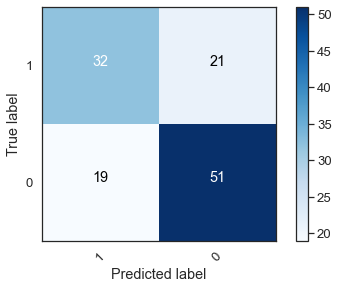

In [91]:
plot_cm('theta', 'central', 'valence', 'knn')

[[41 12]
 [26 44]]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        53
           1       0.79      0.63      0.70        70

    accuracy                           0.69       123
   macro avg       0.70      0.70      0.69       123
weighted avg       0.71      0.69      0.69       123



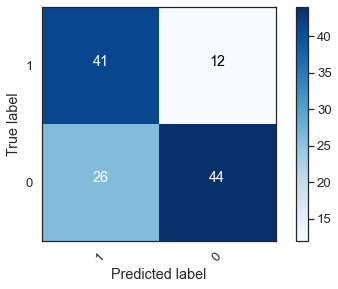

In [92]:
plot_cm('beta', 'left', 'valence', 'knn')

[[33 20]
 [18 52]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        53
           1       0.72      0.74      0.73        70

    accuracy                           0.69       123
   macro avg       0.68      0.68      0.68       123
weighted avg       0.69      0.69      0.69       123



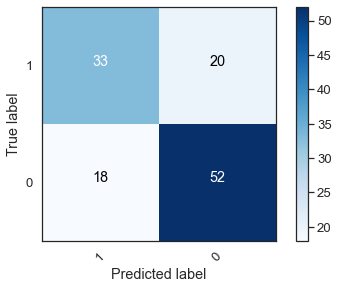

In [93]:
plot_cm('gamma', 'right', 'valence', 'knn')

#### Top combinations for Arousal

[[17 44]
 [ 8 54]]
              precision    recall  f1-score   support

           0       0.68      0.28      0.40        61
           1       0.55      0.87      0.67        62

    accuracy                           0.58       123
   macro avg       0.62      0.57      0.54       123
weighted avg       0.61      0.58      0.54       123



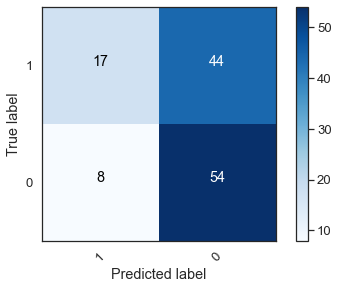

In [94]:
plot_cm('theta', 'parietal', 'arousal', 'svm')

In [99]:
import h5py

def save_model_h5(models, model_name, filename):
    with h5py.File(filename, 'a') as file:
        group = file.create_group(model_name)
        for key, value in model.__dict__.items():
            if isinstance(value, (int, float, str, list, np.ndarray)):
                group[key] = value
            # Add additional checks based on the model attributes if needed

    print(f"Saved {model_name} model to {filename}")

# Assuming you have defined your features (x_train) and labels (y_train)
# Also assuming you have trained the models clf_svm, clf_knn, and clf_mlp

# Save SVM model to an HDF5 file
save_model_h5(clf_svm, 'SVM', 'SVM_models.h5')

# Save k-NN model to an HDF5 file
save_model_h5(clf_knn, 'k-NN', 'KNN_models.h5')




Saved SVM model to SVM_models.h5
Saved k-NN model to KNN_models.h5
